In [1]:
import glob
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
print(tf.__version__)
keras = tf.keras
import matplotlib.pyplot as plt

2.3.0


In [2]:
# train_file_list = glob.glob('./train/*')
train_id_list = [(cv2.imread(_, cv2.IMREAD_GRAYSCALE), int(_.split('_')[-1].split('.')[0][0])) for _ in glob.glob('./train/*')]

# test_file_list = glob.glob('./test/*')
test_id_list = [(cv2.imread(_, cv2.IMREAD_GRAYSCALE), int(_.split('_')[-1].split('.')[0][0])) for _ in glob.glob('./test/*')]

In [3]:
test_id_list

[(array([[38, 37, 36, ..., 48, 46, 45],
         [38, 38, 37, ..., 48, 47, 46],
         [38, 38, 39, ..., 49, 48, 47],
         ...,
         [35, 35, 36, ..., 43, 41, 39],
         [36, 36, 37, ..., 49, 44, 42],
         [36, 37, 38, ..., 51, 46, 43]], dtype=uint8),
  4),
 (array([[43, 43, 43, ..., 43, 43, 42],
         [41, 42, 43, ..., 43, 42, 42],
         [37, 39, 44, ..., 41, 41, 40],
         ...,
         [57, 57, 58, ..., 38, 37, 36],
         [52, 53, 56, ..., 33, 37, 40],
         [49, 51, 55, ..., 30, 38, 42]], dtype=uint8),
  3),
 (array([[42, 43, 44, ..., 45, 49, 50],
         [45, 45, 46, ..., 46, 49, 50],
         [49, 49, 49, ..., 49, 49, 49],
         ...,
         [45, 43, 39, ..., 55, 55, 55],
         [43, 41, 38, ..., 60, 61, 61],
         [42, 40, 38, ..., 62, 64, 64]], dtype=uint8),
  1),
 (array([[38, 40, 45, ..., 48, 51, 52],
         [37, 39, 43, ..., 49, 51, 52],
         [34, 36, 38, ..., 51, 51, 52],
         ...,
         [57, 55, 50, ..., 43, 42, 42],
 

In [4]:
train_X = np.concatenate([np.expand_dims(np.expand_dims(_[0], 0),-1) for _ in train_id_list], 0).astype(float)
train_y = np.concatenate([np.expand_dims(_[1], 0) for _ in train_id_list], 0).astype(float)

test_X = np.concatenate([np.expand_dims(np.expand_dims(_[0], 0),-1) for _ in test_id_list], 0).astype(float)
test_y = np.concatenate([np.expand_dims(_[1], 0) for _ in test_id_list], 0).astype(float)


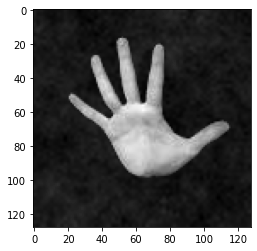

In [5]:
plt.imshow(train_X[0,...,0],cmap='gray')
plt.show()

In [6]:
train_X.shape, train_y.shape

((18000, 128, 128, 1), (18000,))

In [7]:
test_X.shape, test_y.shape

((3600, 128, 128, 1), (3600,))

In [8]:
layers = keras.layers

In [9]:
def create_resnet_id_layer(inputs):
    conv2d = layers.Conv2D(3,(3,3))(inputs)
    bn = layers.BatchNormalization()(conv2d)
    relu = layers.Activation(activation='relu')(bn)
    
    conv2d = layers.Conv2D(3,(3,3))(relu)
    bn = layers.BatchNormalization()(conv2d)
    relu = layers.Activation(activation='relu')(bn)
    
    conv2d = layers.Conv2D(3,(3,3))(relu)
    bn = layers.BatchNormalization()(conv2d)
    
    conv_inputs = layers.Conv2D(3, (7,7))(inputs)
    bn_ci = layers.BatchNormalization()(conv_inputs)
    
    return bn_ci + bn

In [10]:
def invert_colors(image):
    if np.random.uniform() > 0.5:
        image = 255 - image
    return image

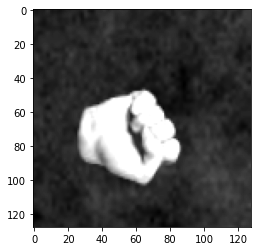

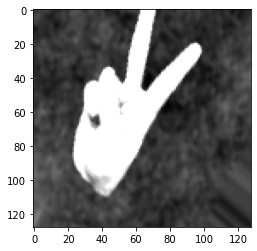

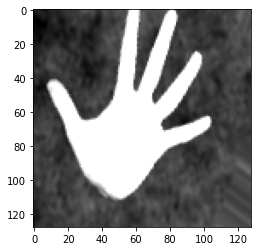

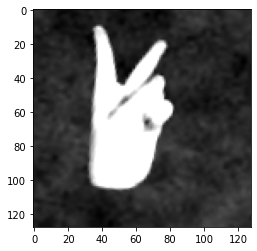

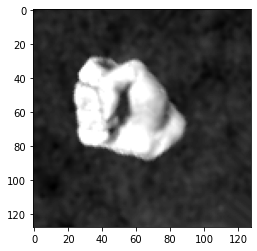

In [11]:
tf.random.set_seed(34)
np.random.seed(34)

aug = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=90,
    zoom_range=[0.5, 1.0],
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.1,1.5),
    channel_shift_range=100,
#     shear_range=30,
    shear_range=0.1,
    fill_mode="nearest",
    
    validation_split=0.2,
)

x_batch, y_batch = next(aug.flow(train_X, train_y))

for i in range (0,5):
    image = x_batch[i]
    plt.imshow(image, cmap='gray')
    plt.show()

In [12]:

inputs = layers.Input(shape=(128, 128, 1))

# model = keras.Sequential([
#     keras.Input(shape=(128, 128, 1)),
#     layers.Conv2D(3,(3,3), activation='elu'),
#     layers.Conv2D(3,(3,3), activation='elu'),
#     layers.Conv2D(3,(3,3), activation='elu'),
#     layers.MaxPooling2D((3,3)),
#     layers.Conv2D(6,(3,3), activation='elu'),
#     layers.Conv2D(6,(3,3), activation='elu'),
#     layers.Conv2D(6,(3,3), activation='elu'),
#     layers.MaxPooling2D((3,3)),
#     layers.Conv2D(6,(3,3), activation='elu'),
#     layers.Conv2D(6,(3,3), activation='elu'),
#     layers.Conv2D(6,(3,3), activation='elu'),
#     layers.MaxPooling2D((3,3)),
#     layers.Reshape((-1,)),
#     layers.Dense(1, activation='sigmoid')
# ])

a = create_resnet_id_layer(inputs)
# a = layers.AveragePooling2D((2,2))(a)
a = layers.MaxPooling2D((2,2))(a)
relu = layers.Activation(activation='relu')(a)
b = create_resnet_id_layer(relu)
# b = layers.AveragePooling2D((2,2))(b)
b = layers.MaxPooling2D((2,2))(b)
relu = layers.Activation(activation='relu')(b)
c = create_resnet_id_layer(relu)
# c = layers.AveragePooling2D((2,2))(c)
c = layers.MaxPooling2D((2,2))(c)
relu = layers.Activation(activation='relu')(c)
d = create_resnet_id_layer(relu)
# d = layers.AveragePooling2D((2,2))(d)
d = layers.MaxPooling2D((2,2))(d)
relu = layers.Activation(activation='relu')(d)

# a = layers.Conv2D(3,(3,3), activation='elu')(inputs)
rshp = layers.Reshape((-1,))(relu)
outputs = layers.Dense(6, activation='softmax')(rshp)

model = keras.Model(inputs=inputs,outputs=outputs)

model.compile(optimizer="Adam",
              loss="sparse_categorical_crossentropy",
#               callbacks=tf.keras.callbacks.EarlyStopping(
#                   monitor="val_loss",
#                   min_delta=0,
#                   patience=5,
#                   verbose=0,
#                   mode="auto",
#                   restore_best_weights=True),
              metrics=['acc'])

history = model.fit(aug.flow(train_X, train_y, batch_size=32, subset='training'),
          validation_data=aug.flow(train_X, train_y, subset='validation'),
          epochs=50)

Epoch 1/50
450/450 [==============================] - 206s 459ms/step - loss: 1.8475 - acc: 0.2224 - val_loss: 1.7336 - val_acc: 0.2306
Epoch 2/50
450/450 [==============================] - 205s 455ms/step - loss: 1.5640 - acc: 0.3208 - val_loss: 1.4341 - val_acc: 0.3789
Epoch 3/50
450/450 [==============================] - 221s 492ms/step - loss: 1.2986 - acc: 0.4100 - val_loss: 1.4097 - val_acc: 0.3328
Epoch 4/50
450/450 [==============================] - 227s 505ms/step - loss: 1.1634 - acc: 0.4592 - val_loss: 1.1806 - val_acc: 0.4517
Epoch 5/50
450/450 [==============================] - 219s 487ms/step - loss: 1.0961 - acc: 0.4971 - val_loss: 1.0890 - val_acc: 0.4892
Epoch 6/50
450/450 [==============================] - 226s 503ms/step - loss: 1.0304 - acc: 0.5365 - val_loss: 1.0178 - val_acc: 0.5431
Epoch 7/50
450/450 [==============================] - 257s 570ms/step - loss: 0.9776 - acc: 0.5674 - val_loss: 1.3412 - val_acc: 0.3764
Epoch 8/50
450/450 [============================

In [39]:
model.evaluate(aug.flow(train_X, train_y, batch_size=32, subset='training'))

450/450 [==============================] - 39s 86ms/step - loss: 0.4195 - acc: 0.8408


[0.41951656341552734, 0.840833306312561]

In [40]:
model.evaluate(aug.flow(train_X, train_y, subset='validation'))

113/113 [==============================] - 10s 86ms/step - loss: 0.4389 - acc: 0.8367


[0.43892645835876465, 0.8366666436195374]

In [13]:
model.evaluate(test_X, test_y)

113/113 [==============================] - 9s 81ms/step - loss: 0.4796 - acc: 0.8317


[0.4796193242073059, 0.8316666483879089]

In [42]:
pred_vals = np.argmax(model.predict(test_X),-1)

In [43]:
from sklearn.metrics import confusion_matrix

In [45]:
conf_matr = confusion_matrix(test_y, pred_vals)

In [49]:
np.round(conf_matr/conf_matr.sum(-1),3)

array([[0.997, 0.003, 0.   , 0.   , 0.   , 0.   ],
       [0.047, 0.953, 0.   , 0.   , 0.   , 0.   ],
       [0.005, 0.19 , 0.805, 0.   , 0.   , 0.   ],
       [0.   , 0.027, 0.182, 0.788, 0.003, 0.   ],
       [0.   , 0.   , 0.032, 0.403, 0.565, 0.   ],
       [0.   , 0.   , 0.005, 0.04 , 0.073, 0.882]])

In [50]:
conf_matr

array([[598,   2,   0,   0,   0,   0],
       [ 28, 572,   0,   0,   0,   0],
       [  3, 114, 483,   0,   0,   0],
       [  0,  16, 109, 473,   2,   0],
       [  0,   0,  19, 242, 339,   0],
       [  0,   0,   3,  24,  44, 529]])

In [68]:
correct = test_X[(test_y == pred_vals),...]
correct_y = test_y[(test_y == pred_vals),...]
correct_pred = pred_vals[(test_y == pred_vals),...]

wrong = test_X[(test_y != pred_vals),...]
wrong_y = test_y[(test_y != pred_vals),...]
wrong_pred = pred_vals[(test_y != pred_vals),...]

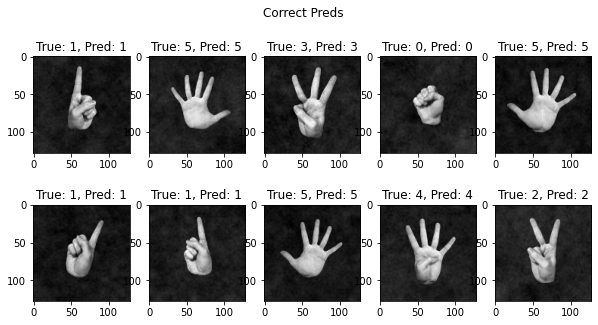

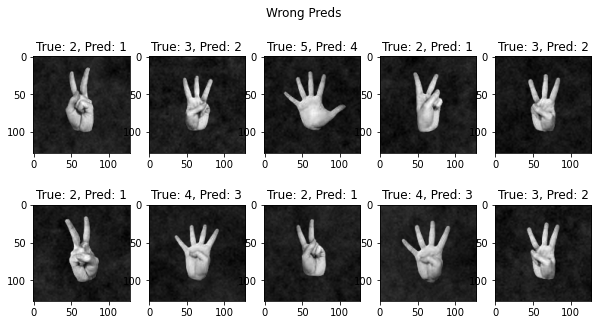

In [97]:
fig, ax = plt.subplots(2,5)

fig.suptitle('Correct Preds', fontsize=12)

fig.set_figheight(5)
fig.set_figwidth(10)

strt_inx = 25
end_inx = 35
for i in range(strt_inx, end_inx):
    ax[(i-strt_inx)//5, (i-strt_inx)%5].imshow(correct[i,...],cmap='gray')
    ax[(i-strt_inx)//5, (i-strt_inx)%5].set_title(f'True: {np.int(correct_y[i])}, Pred: {correct_pred[i]}')
plt.show()


fig, ax = plt.subplots(2,5)

fig.suptitle('Wrong Preds', fontsize=12)

fig.set_figheight(5)
fig.set_figwidth(10)

strt_inx = 20
end_inx = 30
for i in range(strt_inx, end_inx):
    ax[(i-strt_inx)//5, (i-strt_inx)%5].imshow(wrong[i,...],cmap='gray')
    ax[(i-strt_inx)//5, (i-strt_inx)%5].set_title(f'True: {np.int(wrong_y[i])}, Pred: {wrong_pred[i]}')
plt.show()


In [14]:
model.save('handnums_noaug_5')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: handnums_noaug_5/assets


In [15]:
test_X[0,...].squeeze(), test_y[0,...].squeeze()

(array([[38., 37., 36., ..., 48., 46., 45.],
        [38., 38., 37., ..., 48., 47., 46.],
        [38., 38., 39., ..., 49., 48., 47.],
        ...,
        [35., 35., 36., ..., 43., 41., 39.],
        [36., 36., 37., ..., 49., 44., 42.],
        [36., 37., 38., ..., 51., 46., 43.]]),
 array(4.))

In [16]:
test_id_list[0]

(array([[38, 37, 36, ..., 48, 46, 45],
        [38, 38, 37, ..., 48, 47, 46],
        [38, 38, 39, ..., 49, 48, 47],
        ...,
        [35, 35, 36, ..., 43, 41, 39],
        [36, 36, 37, ..., 49, 44, 42],
        [36, 37, 38, ..., 51, 46, 43]], dtype=uint8),
 4)

In [17]:
model.predict(test_X[0:1,...])

array([[1.2261610e-38, 6.8131141e-17, 8.6055991e-07, 5.5236418e-02,
        9.4418812e-01, 5.7463231e-04]], dtype=float32)

In [18]:
my_hand = cv2.imread('./my_hands/mh-2.jpeg', cv2.IMREAD_GRAYSCALE)
# my_hand = cv2.imread('./my_hands/mh-2.jpeg', cv2.IMREAD_GRAYSCALE)
kernel = np.ones((100,100),np.uint8)
opening = my_hand #cv2.morphologyEx(my_hand, cv2.MORPH_OPEN, kernel)

In [19]:
my_hand_scl = opening

In [20]:
my_hand_crop = my_hand_scl[(my_hand_scl.shape[0]-3224):(my_hand_scl.shape[0]-200)]
my_hand_rsz = cv2.resize(my_hand_crop,(128,128))
my_hand_final = np.expand_dims(np.expand_dims(my_hand_rsz, 0),-1)

In [21]:
my_hand_final.shape

(1, 128, 128, 1)

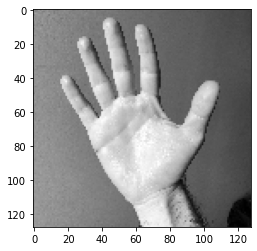

In [22]:
plt.imshow(my_hand_final[0,...],cmap='gray')
plt.show()

In [23]:
model.predict(my_hand_final)

array([[4.1693115e-01, 3.5709682e-01, 1.7705718e-01, 4.4284370e-02,
        4.2468794e-03, 3.8365269e-04]], dtype=float32)

In [24]:
import keras2onnx
import onnx
from PIL import Image
import onnxruntime as rt

In [25]:
onnx_model = keras2onnx.convert_keras(model, 'finger_count_5')
onnx.save_model(onnx_model, 'finger_count_5.onnx')

tf executing eager_mode: True
tf.keras model eager_mode: False
The ONNX operator number change on the optimization: 152 -> 43


In [26]:
sess = rt.InferenceSession('finger_count_5.onnx')

In [27]:

image = Image.open('./my_hands/mh-2.jpeg').convert('L')
image = image.crop((image.size[0]-3224,0,image.size[0]-200,image.size[1]))
image = image.resize((int(128), int(128)), Image.ANTIALIAS)
x = np.array(image).astype('float32')
x = np.flip(np.transpose(x, [1, 0]),-1)
x = np.expand_dims(np.expand_dims(x, axis=0),axis=-1)

print(x.shape)

# Stylize image.
sess = rt.InferenceSession('finger_count_5.onnx')
input_name = sess.get_inputs()[0].name
pred_onx = sess.run(None, {input_name: x})[0]

(1, 128, 128, 1)


In [28]:
image.size

(128, 128)

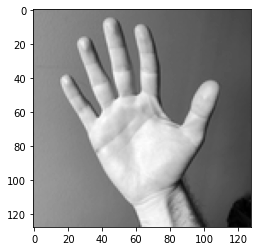

In [29]:
plt.imshow(x[0,...],cmap='gray')

In [30]:

# x = my_hand_final[0,...] if isinstance(my_hand_final[0,...], list) else [my_hand_final[0,...]]
# feed = dict([(input.name, x[n]) for n, input in enumerate(sess.get_inputs())])
# pred_onnx = sess.run(None, feed)[0]
# pred = np.squeeze(pred_onnx)
# top_inds = pred.argsort()[::-1][:5]
# print(img_path)
# for i in top_inds:
#     print('    {:.3f}  {}'.format(pred[i], cls_list[i]))

In [31]:
pred_onx

array([[0.01571413, 0.14130548, 0.37407318, 0.3481281 , 0.08849377,
        0.03228538]], dtype=float32)

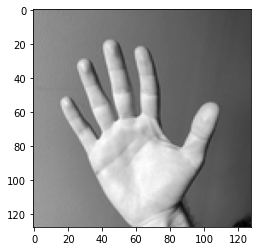

In [32]:
image = Image.open('./my_hands/mh-2.jpeg').convert('L')


height, width = image.size
min_dim = min(width, height)

crp_height = (height - min_dim)//2
crp_width = (width - min_dim)//2

top = crp_height
bot = height - crp_height
left = crp_width
right = width - crp_width

image = image.crop((top, left, bot, right))


# image = image.crop((image.size[0]-3224,0,image.size[0]-200,image.size[1]))
image = image.resize((int(128), int(128)), Image.ANTIALIAS)
x = np.array(image).astype('float32')
x = np.flip(np.transpose(x, [1, 0]),-1)
x = np.expand_dims(np.expand_dims(x, axis=0),axis=-1)

plt.imshow(x[0,...],cmap='gray')

image.shape 2 (3024, 4032, 3)
image.shape 3 (3024, 4032)
False


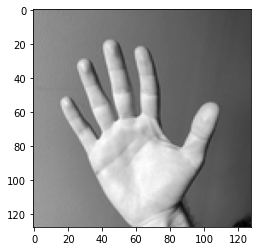

In [33]:
image = Image.open('./my_hands/mh-2.jpeg')

is_greyscale = len(np.array(image).shape) == 2
print('image.shape 2',np.array(image).shape)
image = image.convert('L')
print('image.shape 3',np.array(image).shape)

print(is_greyscale)

height, width = image.size
min_dim = min(width, height)

crp_height = (height - min_dim)//2
crp_width = (width - min_dim)//2

top = crp_height
bot = height - crp_height
left = crp_width
right = width - crp_width


# image = Image.crop((image.size[0]-3224, 0, image.size[0]-200, image.size[1]))
image = image.crop((top, left, bot, right))

smaller_image = image.resize((int(128), int(128)), Image.ANTIALIAS)
numpy_smaller_image = np.asarray(smaller_image)
numpy_smaller_image = numpy_smaller_image.astype("float32")# / 255

if not is_greyscale:
    numpy_smaller_image = np.flip(np.transpose(numpy_smaller_image, [1, 0]),-1)

numpy_smaller_image = np.expand_dims(np.expand_dims(numpy_smaller_image, axis=0),axis=-1)

plt.imshow(numpy_smaller_image[0,...],cmap='gray')



(128, 128)
[[1.5793630e-01 8.3951604e-01 2.5468546e-03 8.2987134e-07 7.2268636e-11
  2.7740089e-18]]


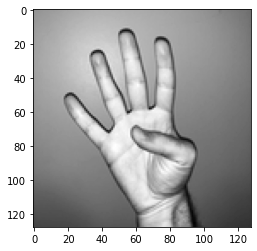

In [34]:
image = Image.open('/Users/josh/Desktop/untitled folder/IMG_0775.jpeg').convert('L')


height, width = image.size
min_dim = min(width, height)

crp_height = (height - min_dim)//2
crp_width = (width - min_dim)//2

top = crp_height
bot = height - crp_height
left = crp_width
right = width - crp_width

image = image.crop((top, left, bot, right))


# image = image.crop((image.size[0]-3224,0,image.size[0]-200,image.size[1]))
image = image.resize((int(128), int(128)), Image.ANTIALIAS)
x = np.array(image).astype('float32')

print(x.shape)

x = np.flip(np.transpose(x, [1, 0]),-1)
x = np.expand_dims(np.expand_dims(x, axis=0),axis=-1)

plt.imshow(x[0,...],cmap='gray')

# Stylize image.
sess = rt.InferenceSession('finger_count_5.onnx')
input_name = sess.get_inputs()[0].name
pred_onx = sess.run(None, {input_name: x})[0]

print(pred_onx)

(128, 128)
[[2.3909151e-21 3.0712754e-06 1.5031241e-01 8.1425893e-01 3.5425503e-02
  6.3553209e-08]]


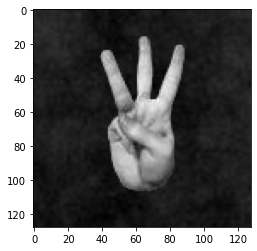

In [35]:
image = Image.open('./my_hands/hand.jpeg')


height, width = image.size
min_dim = min(width, height)

crp_height = (height - min_dim)//2
crp_width = (width - min_dim)//2

top = crp_height
bot = height - crp_height
left = crp_width
right = width - crp_width

image = image.crop((top, left, bot, right))


# image = image.crop((image.size[0]-3224,0,image.size[0]-200,image.size[1]))
image = image.resize((int(128), int(128)), Image.ANTIALIAS)
x = np.array(image).astype('float32')

print(x.shape)

# x = np.flip(np.transpose(x, [1, 0]),-1)
x = np.expand_dims(np.expand_dims(x, axis=0),axis=-1)

plt.imshow(x[0,...],cmap='gray')
x 
# Stylize image.
sess = rt.InferenceSession('finger_count_5.onnx')
input_name = sess.get_inputs()[0].name
pred_onx = sess.run(None, {input_name: x})[0]

print(pred_onx)

In [36]:
history

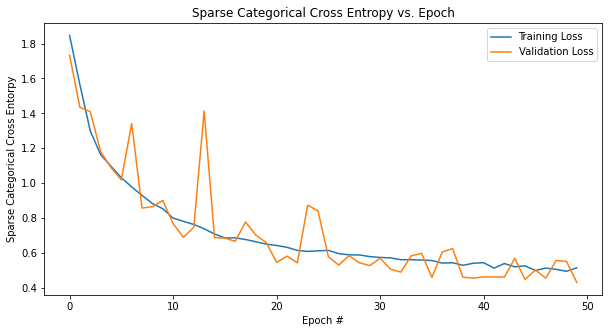

In [38]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Sparse Categorical Cross Entropy vs. Epoch')
plt.ylabel('Sparse Categorical Cross Entorpy')
plt.xlabel('Epoch #')
plt.legend(['Training Loss', 'Validation Loss'])